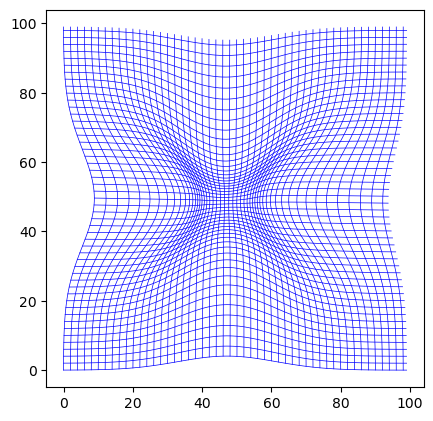

In [1]:
import torch
import numpy as np
from Packages.RegistrationFunc import *
from Packages.SplitEbinMetric import *
from Packages.GeoPlot import *
import scipy.io as sio
import matplotlib.pyplot as plt


diffeo = sio.loadmat('Data/diffeo1.mat')['diffeo']
range0 = np.max(diffeo[0,:,:])-np.min(diffeo[0,:,:])
range1 = np.max(diffeo[1,:,:])-np.min(diffeo[1,:,:])
diffeo[0,:,:] = (diffeo[0,:,:]-np.min(diffeo[0,:,:]))/range0*(diffeo.shape[1]-1)
diffeo[1,:,:] = (diffeo[1,:,:]-np.min(diffeo[1,:,:]))/range1*(diffeo.shape[2]-1)
diffeo = torch.from_numpy(diffeo).double()

g00 = sio.loadmat('Data/tensor1b.mat')
g00 = torch.from_numpy(g00['tensor']).double()

# mask = sio.loadmat('Data/105923_filt_mask.mat')
# mask = torch.from_numpy(mask['mask']).double().unsqueeze(0) 
mask = torch.ones_like(diffeo[1,:,:]).unsqueeze(0) 

# temp1 = diffeo[1,:,:]
# temp0 = diffeo[0,:,:]
# diffeo = torch.stack((temp1,temp0))

plot_diffeo(diffeo,  step_size=2, show_axis=True)

In [2]:
# define the pullback action of phi
def phi_pullback(phi, g):
    idty = get_idty(*g.shape[-2:])
#     four layers of scalar field, of all 1, all 0, all 1, all 0, where the shape of each layer is g.shape[-2:]?
    d_phi = get_jacobian_matrix(phi - idty) + torch.einsum("ij,mn->ijmn", [torch.eye(2,dtype=torch.double),
                                                                           torch.ones(g.shape[-2:],dtype=torch.double)])
    g_phi = compose_function(g, phi)
#     matrix multiplication
# the last two dimension stays the same means point-wise multiplication, ijmn instead of jimn means the first d_phi need to be transposed
    return torch.einsum("ijmn,ikmn,klmn->jlmn",[d_phi, g_phi, d_phi])


# define the energy functional
def Energy(phi, g0, g1, f0, f1, sigma, lambd, mask): 

    '''
    compute the energy functional
    
    Parameters
    -----
    phi: the diffeomorphism
        size: 2 x N x N
        
    g0, g1: the initial and the target metrics
        size: 2 x 2 x N x N
        
    f0, f1: weighting tensors
        size: 2 x 2 x N x N
    
    sigma: the constant regularization parameter
    
    lambd: the weight that measures the change in the volumn density
    
    Returns
    -----
    The energy fuctional 
    
    ''' 
    phi_star_g1 = phi_pullback(phi, g1)
    phi_star_f1 = phi_pullback(phi, f1)
#     means d(g_0,\phi^*g_1)=d(\phi_*g_0,g_1), d(f_0,\phi^*f_1)=d(\phi_*f_0,f_1)?
    E1 = sigma*Squared_distance_Ebin(f0, phi_star_f1, lambd, mask)
    E2 = Squared_distance_Ebin(g0, phi_star_g1, lambd, mask)
    
    return E1 + E2


# define the energy functional
def Energy_L2(phi, g0, g1, f0, f1, sigma, weight): # 

    '''
    compute the energy functional
    
    Parameters
    -----
    phi: the diffeomorphism
        size: 2 x N x N
        
    g0, g1: the initial and the target metrics
        size: 2 x 2 x N x N
        
    f0, f1: weighting tensors
        size: 2 x 2 x N x N
    
    sigma: the constant regularization parameter
    
    lambd: the weight that measures the change in the volumn density
    
    Returns
    -----
    The energy fuctional 
    
    ''' 
    phi_star_g1 = phi_pullback(phi, g1)
    phi_star_f1 = phi_pullback(phi, f1)
    
#     E1 = sigma*torch.sum((f0 - phi_star_f1)**2)
#     E2 = torch.sum((g0 - phi_star_g1)**2)
    E1 = sigma*torch.einsum("...ij,kij->",[(f0 - phi_star_f1)**2, weight])
    E2 = torch.einsum("...ij,kij->",[(g0 - phi_star_g1)**2, weight])
    
    return E1 + E2

In [3]:
height = g00.size(-2)
width = g00.size(-1)
g0, g1 = torch.zeros(2,2,height,width,dtype=torch.double), torch.zeros(2,2,height,width,dtype=torch.double)
g0[0,0,:,:] = g00[0,:,:]
g0[0,1,:,:] = g00[1,:,:]
g0[1,0,:,:] = g00[1,:,:]
g0[1,1,:,:] = g00[2,:,:]

g1 = phi_pullback(diffeo,g0)

# mask_phi = compose_function(mask, diffeo)
# mask_phi[mask_phi>=0.5] = 1
# mask_phi[mask_phi<0.5] = 0   
# print(np.unique(mask_phi.squeeze().detach().numpy()))
# det = g1[0,0,:,:]*g1[1,1,:,:]-g1[0,1,:,:]*g1[0,1,:,:]
# weight = mask_phi/det
# plt.imshow(mask_phi.squeeze().detach().numpy())
# plt.show()

In [4]:
# %matplotlib qt
%matplotlib inline
# show_2d_tensors(g0, scale=0.5, title="g0", margin=0.05, dpi=20)
# show_2d_tensors(g1, scale=0.5, title="g1", margin=0.05, dpi=20)
show_2d_tensors_kris(g1, scale=0.5, title=None, margin=0.05, dpi=80, has_component_data=False)

AttributeError: 'Tensor' object has no attribute 'GetPixelIDValue'

In [5]:
def laplace_inverse(u):
    '''
    this function computes the laplacian inverse of a vector field u of size 2 x size_h x size_w 
    '''
    size_h, size_w = u.shape[-2:]
    shape = u.shape
    idty = get_idty(size_h, size_w).numpy()
    lap = 4. - 2.*(np.cos(2.*np.pi*idty[0]/size_w) + np.cos(2.*np.pi*idty[1]/size_h))
    lap[0,0] = 1.
    lapinv = 1./lap
    lap[0,0] = 0.
    lapinv[0,0] = 1.
    
    u = u.detach().numpy()
    fx = np.fft.fftn(u[0])
    fy = np.fft.fftn(u[1])
    fx *= lapinv
    fy *= lapinv
    vx = torch.from_numpy(np.real(np.fft.ifftn(fx)))
    vy = torch.from_numpy(np.real(np.fft.ifftn(fy)))
    
    return torch.stack((vx,vy))

In [6]:
def checkNaN(A):
    if (A != A).any():
        print('NaN')

## Pytorch

In [7]:
%%time

%matplotlib inline

lambd = 0.5

sigma = 0
epsilon = 5e-4
Num_ite = 1000
count = 0

phi_inv = get_idty(height, width)
phi = get_idty(height, width)

idty = get_idty(height, width)
idty.requires_grad_()
E_all = []
epsilon_all = []

CPU times: user 2.46 ms, sys: 225 µs, total: 2.68 ms
Wall time: 2.46 ms


In [8]:
# 2*2*N*N?
# f0 = torch.eye(2, dtype=torch.double).repeat(height, width,1,1).permute(2,3,0,1)
# f1 = torch.eye(2, dtype=torch.double).repeat(height, width,1,1).permute(2,3,0,1)
# E = torch.tensor([np.inf], dtype=torch.double) 

# for i in range(Num_ite):
# #     print(i)
#     phi_actsg0 = phi_pullback(phi_inv, g0)
#     phi_actsf0 = phi_pullback(phi_inv, f0)
    
#     E0 = E.clone()
# #     mask_phi = compose_function(mask, phi)
# #     mask_phi[mask_phi>=0.5] = 1
# #     mask_phi[mask_phi<0.5] = 0    
#     E = Energy_L2(idty, phi_actsg0, g1, phi_actsf0, f1, sigma, mask) #, lambd)
#     E.backward()
    
# #     if (E - E0) / E0 > 0:  
# #         epsilon = epsilon/2
# #         count+=1
# #         print(count)
    
#     v = - laplace_inverse(idty.grad)
#     E_all.append(E.item())
#     epsilon_all.append(epsilon)
    
#     with torch.no_grad():
#         psi =  idty + epsilon*v  
#         psi[0][psi[0]>width-1]=width-1
#         psi[1][psi[1]>height-1]=height-1
#         psi[psi<0]=0
        
#         psi_inv =  idty - epsilon*v
#         psi_inv[0][psi_inv[0]>width-1]=width-1
#         psi_inv[1][psi_inv[1]>height-1]=height-1
#         psi_inv[psi_inv<0]=0
        
#         phi = compose_function(psi, phi)
#         phi_inv = compose_function(phi_inv, psi_inv)
        
#         if i%100==0:
#             plot_diffeo(phi, step_size=2, show_axis=True)
# #         if i%100==0:
#             print(E.item())
        
#         idty.grad.data.zero_()
    
#     if abs((E-E0)/E0)<1e-10:
#         print()
#         break
        
# print(E.grad_fn)

In [9]:
# plt.plot(E_all)

In [10]:
# g11_n = phi_pullback(phi_inv, g0)
# show_2d_tensors(g1, scale=0.5, title="g1", margin=0.05, dpi=20)
# show_2d_tensors(g11_n, scale=0.5, title="recoverd g1", margin=0.05, dpi=20)
# show_2d_tensors(g0, scale=0.5, title="g0", margin=0.05, dpi=20)

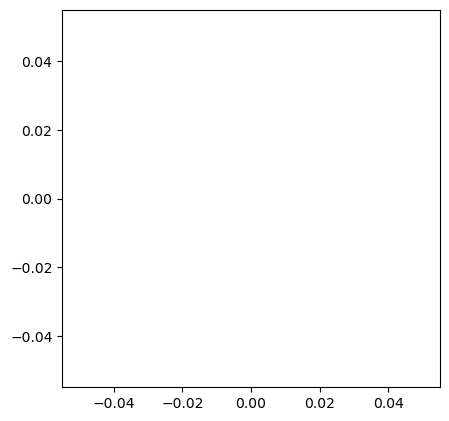

17720.85851004364


RuntimeError: cholesky_cpu: For batch 0: U(1,1) is zero, singular U.

In [11]:
%%time

epsilon = 1e-4
Num_ite = 2000
count = 0

f0 = torch.eye(2, dtype=torch.double).repeat(height, width,1,1).permute(2,3,0,1)
f1 = torch.eye(2, dtype=torch.double).repeat(height, width,1,1).permute(2,3,0,1)
E = torch.tensor([np.inf], dtype=torch.double) 

for i in range(Num_ite):
#     print(i)
    phi_actsg0 = phi_pullback(phi_inv, g0)
    phi_actsf0 = phi_pullback(phi_inv, f0)
    
    E0 = E.clone()
    E = Energy(idty, phi_actsg0, g1, phi_actsf0, f1, sigma, lambd, mask)
    E.backward()    
    if np.isnan(E.item()):
        print(i,'nan issue')
        break
    else:
        E_all.append(E.item())
    
#     if (E - E0) / E0 > 0:
#         epsilon = epsilon/2
#         count+=1
#         print(count)

    v = - laplace_inverse(idty.grad)
        
    with torch.no_grad():
        psi =  idty + epsilon*v  
        psi[0][psi[0]>width-1]=width-1
        psi[1][psi[1]>height-1]=height-1
        psi[psi<0]=0
        
        psi_inv =  idty - epsilon*v  
        psi_inv[0][psi_inv[0]>width-1]=width-1
        psi_inv[1][psi_inv[1]>height-1]=height-1
        psi_inv[psi_inv<0]=0
        
        phi = compose_function(psi, phi)
        phi_inv = compose_function(phi_inv, psi_inv)
        
        if i%100==0:
            plot_diffeo(phi, step_size=2, show_axis=True)
            print(E.item())
            
        idty.grad.data.zero_()
        
    if abs((E-E0)/E0)<1e-11:# or count>=200
        break
        

In [ ]:
print(E_all[-1])
plt.plot(E_all)

In [ ]:
# %matplotlib qt
show_2d_tensors(g0, scale=0.5, title="g0", margin=0.05, dpi=20)
show_2d_tensors(g1, scale=0.5, title="g1", margin=0.05, dpi=20)

plot_diffeo(phi, title="phi", step_size=2, show_axis=True)
plot_diffeo(phi_inv, title="phi_inv", step_size=2, show_axis=True)

In [ ]:
g1_n = phi_pullback(phi_inv, g0)

In [ ]:
# %matplotlib qt
#[:,:,25:50,60:80]
show_2d_tensors(g1, scale=0.5, title="g1", margin=0.05, dpi=20)
show_2d_tensors(g11_n, scale=0.5, title="g1 recovered by L2", margin=0.05, dpi=20)
show_2d_tensors(g1_n, scale=0.5, title="g1 recovered by L2+Ebin", margin=0.05, dpi=20)
show_2d_tensors(g0, scale=0.5, title="g0", margin=0.05, dpi=20)

In [ ]:
# det_gamma = get_jacobian_determinant(phi_inv)
# fig = plt.figure()
# im = plt.imshow(det_gamma)
# fig.colorbar(im)
# plt.show()
# plt.savefig(str(name)+'jacobian.png')

In [ ]:
# sio.savemat('Data/103818to105923_phi_inv_20k.mat', {'diffeo': phi_inv.detach().numpy()})

In [ ]:
# sio.savemat('Data/103818to105923_phi_20k.mat', {'diffeo': phi.detach().numpy()})

In [ ]:
dist_g0_g1 = Squared_distance_Ebin(g0, g1, lambd, mask)
fig = plt.figure()
im = plt.imshow(dist_g0_g1.detach().numpy())
fig.colorbar(im)
plt.show()
# plt.savefig(str(name)+'jacobian.png')

In [ ]:
dist_g1n_g1 = Squared_distance_Ebin(g1_n, g1, lambd, mask)
fig = plt.figure()
im = plt.imshow(dist_g1n_g1.detach().numpy())
fig.colorbar(im)
plt.show()
# plt.savefig(str(name)+'jacobian.png')